In [2]:
%load_ext autoreload
%autoreload 2
# testing habitat lab setup
import sys
import math
import io
from typing import Dict, Any
import numpy as np
import quaternion
from scipy.spatial.transform import Rotation
from habitat.core.utils import try_cv2_import
from habitat.utils.visualizations import maps
from torchlightning_utils import cli
import matplotlib.pyplot as plt
from PIL import Image

def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    arr = []
    titles = []
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    plt.figure(figsize=(12, 4))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 1, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

/datadrive/anaconda3/envs/habitat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2
data_path = "/datadrive/azure_storage/pactdata/habitat-data/collected-data/test/hm3d/val/0/observations.npz"
data = np.load(data_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
type(data.files)

list

In [3]:
def display_obs(obs: np.ndarray, obs_type: str) -> np.ndarray:
    """Given an image (not rgb), use plt to transform it image rgb image

    Args:
        obs (np.ndarray): observations from sensors with leading two dims should be width and height.

    Returns:
        np.ndarray: rgb repr of img with size (original w, original h, 3)
    """
    from habitat_sim.utils.common import d3_40_colors_rgb
    if obs_type == "semantic":
        obs_img = Image.new("P", (obs.shape[1], obs.shape[0]))
        obs_img.putpalette(d3_40_colors_rgb.flatten())
        obs_img.putdata((obs.flatten() % 40).astype(np.uint8))
        obs_img = obs_img.convert("RGBA")
    elif obs_type == "depth":
        obs_img = Image.fromarray((obs / 10 * 255).astype(np.uint8), mode="L")
    else:
        raise NotImplementedError("observation type not supported for display!")
    fig = plt.figure()
    fig.add_axes([0, 0, 1, 1])  # remove margins
    plt.imshow(obs_img)
    buf = io.BytesIO()
    plt.axis("off")
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    pil_img = Image.open(buf).convert("RGB").resize((obs.shape[1], obs.shape[0]))
    buf.close()
    np_img = np.asarray(pil_img)
    return np_img

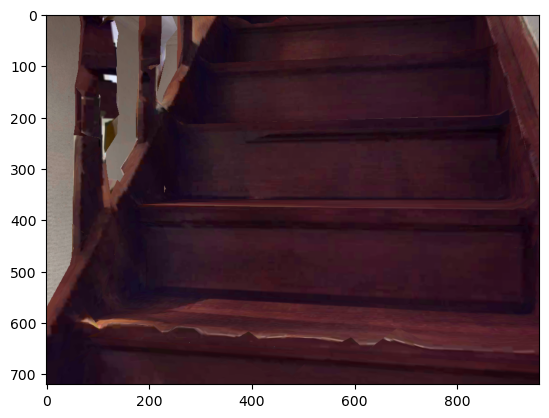

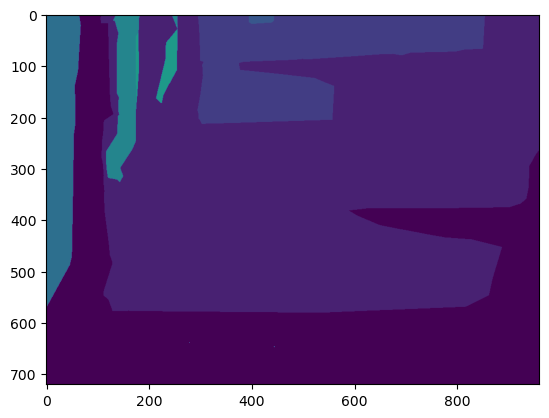

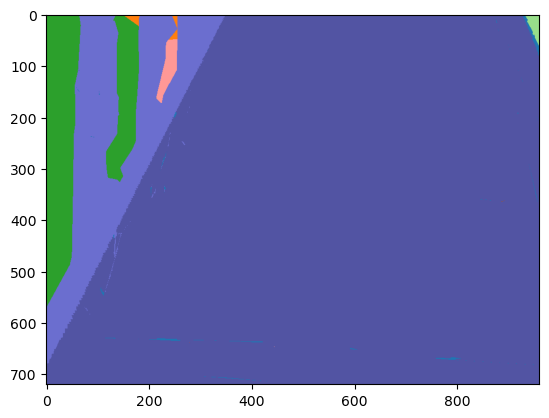

In [23]:
# print(data.files)
# for arr in data.files:
#     print(arr, data[arr].shape)
nth_frame = 50
rgb_img = data["observations-rgb"][nth_frame]
fig = plt.figure()
plt.imshow(rgb_img)
depth_img = data["observations-depth"][nth_frame].squeeze(2)
depth_img = Image.fromarray((depth_img / 10 * 255).astype(np.uint8), mode="L")
fig = plt.figure()
plt.imshow(depth_img)

from habitat_sim.utils.common import d3_40_colors_rgb
semantic_obs = data["observations-semantic"][nth_frame].squeeze(2)
semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
semantic_img.putpalette(d3_40_colors_rgb.flatten())
semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
semantic_img = semantic_img.convert("RGBA")
fig = plt.figure()
plt.imshow(semantic_img)

In [25]:
print(data.files)
for arr in data.files:
    print(arr, data[arr].shape)

['observations-rgb', 'observations-depth', 'observations-semantic', 'observations-equirect_rgb', 'observations-equirect_depth', 'observations-equirect_semantic', 'observations-top_down_rgb', 'observations-top_down_semantic', 'observations-pointgoal_with_gps_compass', 'observations-top_down_map', 'observations-agent_centered_top_down_map', 'action-action', 'pose']
observations-rgb (80, 720, 960, 3)
observations-depth (80, 720, 960, 1)
observations-semantic (80, 720, 960, 1)
observations-equirect_rgb (80, 720, 960, 3)
observations-equirect_depth (80, 720, 960, 1)
observations-equirect_semantic (80, 720, 960, 1)
observations-top_down_rgb (80, 720, 960, 3)
observations-top_down_semantic (80, 720, 960, 1)
observations-pointgoal_with_gps_compass (80, 2)
observations-top_down_map (80, 1024, 4238)
observations-agent_centered_top_down_map (80, 1024, 1024)
action-action (80,)
pose (80, 4)


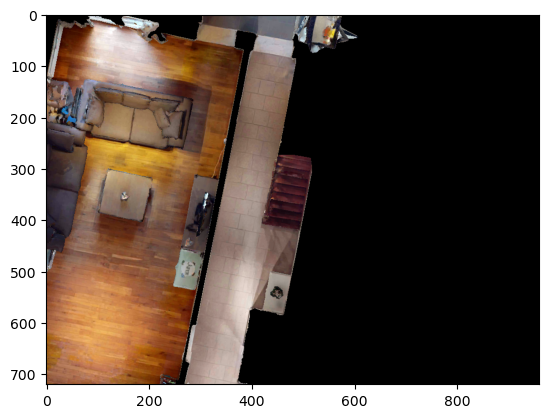

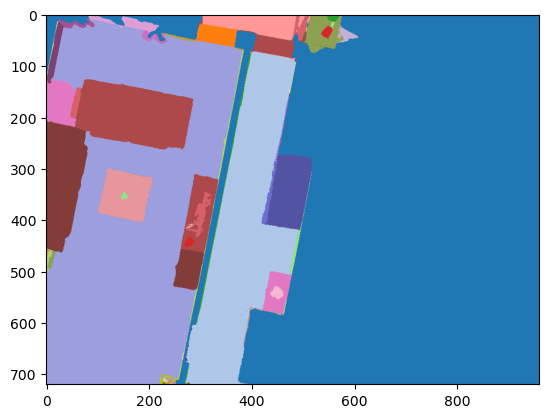

In [27]:
nth_frame = 50
rgb_img = data["observations-top_down_rgb"][nth_frame]
fig = plt.figure()
plt.imshow(rgb_img)

from habitat_sim.utils.common import d3_40_colors_rgb
semantic_obs = data["observations-top_down_semantic"][nth_frame].squeeze(2)
semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
semantic_img.putpalette(d3_40_colors_rgb.flatten())
semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
semantic_img = semantic_img.convert("RGBA")
fig = plt.figure()
plt.imshow(semantic_img)

dict_keys(['observations-rgb', 'observations-depth', 'observations-semantic', 'action-action', 'pose'])


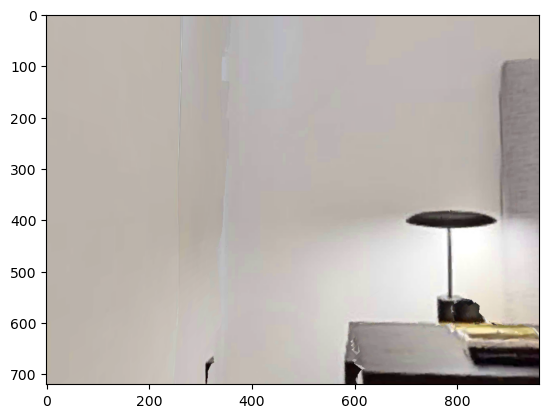

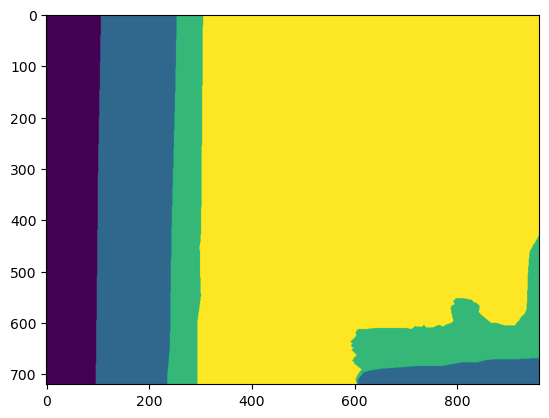

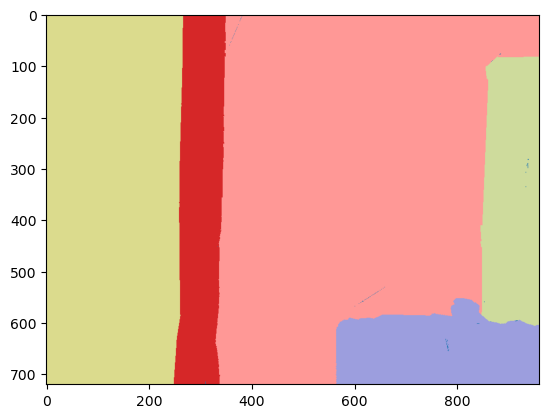

In [4]:
# check saved seqrecord data 
from seqrecorder.seqrecord import SeqRecord

record = SeqRecord.load_record_from_dict(recorddir="/datadrive/azure_storage/pactdata/habitat-data/collected-data/pointnav_sem_v0/hm3d/train/seqrecord")

for item in record.read_items(features=["observations-rgb", "observations-depth", "observations-semantic", "action-action", "pose"]):
    print(item.keys())
    fig = plt.plot()
    plt.imshow(item["observations-rgb"])
    depth_img = item["observations-depth"].squeeze(2)
    depth_img = Image.fromarray((depth_img / 10 * 255).astype(np.uint8), mode="L")
    fig = plt.figure()
    plt.imshow(depth_img)

    from habitat_sim.utils.common import d3_40_colors_rgb
    semantic_obs = item["observations-semantic"].squeeze(2)
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    fig = plt.figure()
    plt.imshow(semantic_img)
    break